In [88]:
# Just to ignore warnings, in general you should NOT use this
import warnings
warnings.filterwarnings("ignore")

#import pyfits #module to read fits files
from astropy.io import fits
import matplotlib.pyplot as plt #module for plotting
import numpy as np #this module is for working with arrays like in matlab
import scipy as sp
from scipy import ndimage
from scipy.optimize import curve_fit

import pandas as pd

In [89]:
cube = fits.open(r"C:\Users\nicol\Documents\Astro_Exp\Informe 2 Experimental\southgal_fixbadc.fits") #open data cube object
data = cube[0].data #extract data matrix
header = cube[0].header #extract the header from the fits file

In [90]:
header

SIMPLE  =                    T  / Standard FITS format                          
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    3  / Number of axes                                
NAXIS1  =                  306  / Number pixels on axis 1                       
NAXIS2  =                  385  / Number pixels on axis 2                       
NAXIS3  =                   33  / Number pixels on axis 3                       
CTYPE1  = 'VELO-LSR'            / axis 1 coord type                             
CRVAL1  =        -2.307985E+02 / coord value at CRPIX1                          
CDELT1  =         1.300400E+00 / pixel spacing for axis 1                       
CRPIX1  =             1.000000  / ref pixel for axis 1                          
CTYPE2  = 'GLON-FLT'            / axis 2 coord type                             
CRVAL2  =         3.000000E+02 / coord value at CRPIX2                          
CDELT2  =         1.250000E-

In [91]:
data.shape

(33, 385, 306)

Aquí es bueno notar que la forma del array data no es necesariamente en el mismo orden de los ejes registrados en el header:  
en este caso, están reflejados, con el header teniendo velocidad, longitud y latitud (se puede ver en los CTYPEi),  
y data teniendo latitud, longitud y velocidad (al comnparar con las dimensiones se puede ver)

In [92]:
def values(h, j):
    N = h['NAXIS' + str(j)]
    val = np.zeros(N)
    for i in range(0, N):
        val[i] = (i + 1 - float(h['CRPIX' + str(j)])) * float(h['CDELT' + str(j)]) + float(h['CRVAL' + str(j)])
    return val

# Esta función, vista en auxiliar, permite extraer los valores del eje j de los datos, tomando en cuenta 
# las posibles diferencias en pixel de referencia, espaciado de pixeles y valores iniciales 

vel = values(header, 1)
lon = values(header, 2)
lat = values(header, 3)

# Por ejemplo, veamos los valores de velocidad:
vel

array([-230.7985, -229.4981, -228.1977, -226.8973, -225.5969, -224.2965,
       -222.9961, -221.6957, -220.3953, -219.0949, -217.7945, -216.4941,
       -215.1937, -213.8933, -212.5929, -211.2925, -209.9921, -208.6917,
       -207.3913, -206.0909, -204.7905, -203.4901, -202.1897, -200.8893,
       -199.5889, -198.2885, -196.9881, -195.6877, -194.3873, -193.0869,
       -191.7865, -190.4861, -189.1857, -187.8853, -186.5849, -185.2845,
       -183.9841, -182.6837, -181.3833, -180.0829, -178.7825, -177.4821,
       -176.1817, -174.8813, -173.5809, -172.2805, -170.9801, -169.6797,
       -168.3793, -167.0789, -165.7785, -164.4781, -163.1777, -161.8773,
       -160.5769, -159.2765, -157.9761, -156.6757, -155.3753, -154.0749,
       -152.7745, -151.4741, -150.1737, -148.8733, -147.5729, -146.2725,
       -144.9721, -143.6717, -142.3713, -141.0709, -139.7705, -138.4701,
       -137.1697, -135.8693, -134.5689, -133.2685, -131.9681, -130.6677,
       -129.3673, -128.0669, -126.7665, -125.4661, 

## Visualización del procedimiento 
 Paso por paso, estaré viendo las funciones del auxiliar para entenderlas,  
 y así poder avanzar luego con la implementación

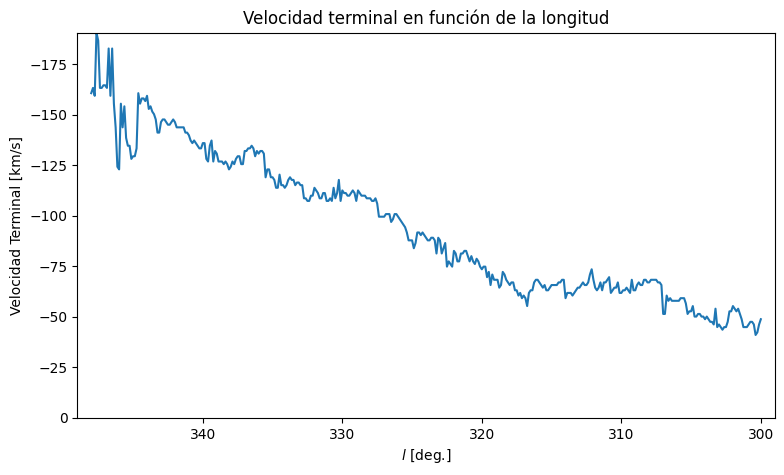

In [93]:
# Separación de las velocidades mínimas con máscaras

mask = data >= 0.8

# Broadcast a las velocidades para poder comparar con los datos en forma de cubo
vel_array = np.broadcast_to(vel, data.shape)

# Cambiamos las velocidades mayores 0.8 a np.inf
masked_vel = np.where(mask, vel_array, np.inf)

# Mínimos de cada (lat, lon)
min_vel = np.min(masked_vel, axis = 2)

# Encontramos los índices de latitud donde data coincide con los mínimos
lat_ind = np.argmin(min_vel, axis = 0)

# Velocidades mínimas por longitud
vt_lon = min_vel[lat_ind, np.arange(min_vel.shape[1])]

# Valores de latitud de los mínimos
lat_b = lat[lat_ind]

mins_table = np.column_stack((lon, lat_b, vt_lon))

######################################################

# Plot de lavelocidad terminal calculada en las longitudes
plt.figure(figsize = (9, 5))
plt.plot(lon, vt_lon)
plt.xlim(349, 299.)
plt.ylim(0, np.min(vt_lon))
plt.xlabel(r'$l$ [deg.]')
plt.ylabel(r'Velocidad Terminal [km/s]')
plt.title('Velocidad terminal en función de la longitud')
plt.show()

In [94]:
from astropy.stats import sigma_clip

columns = ['longitude l', 'latitude b', 'v_tan']
table_data = []  # List to store rows before appending to the DataFrame

for i_b in range(len(lat)):
    for i_l in range(len(lon)):
        T = data[i_b][i_l][:] # Tomamos una "fila" de velocidades correspondientes a un (b, l)
        r = sigma_clip(T, sigma_lower=3, sigma_upper=3) # MaskedArray con quellos que pasan el criterio
        rms = np.sqrt(np.mean(r**2))
        rmask = r.mask # Condicional para aplicar a vel
        if len(vel[rmask]) == 0:
            v_tan = np.nan      # En caso de que ningun valor en ese vel pase el sigma, se deja un NaN
        else:
            v_tan = vel[rmask][0] # En otro caso, se toma el primer dato que pase el sigma
        
        # Se guarda como diccionario cada 3-tupla
        table_data.append({'longitude l': lon[i_l], 'latitude b': lat[i_b], 'v_tan': v_tan})

# DataFrame con los datos 
table = pd.DataFrame(table_data, columns=columns)

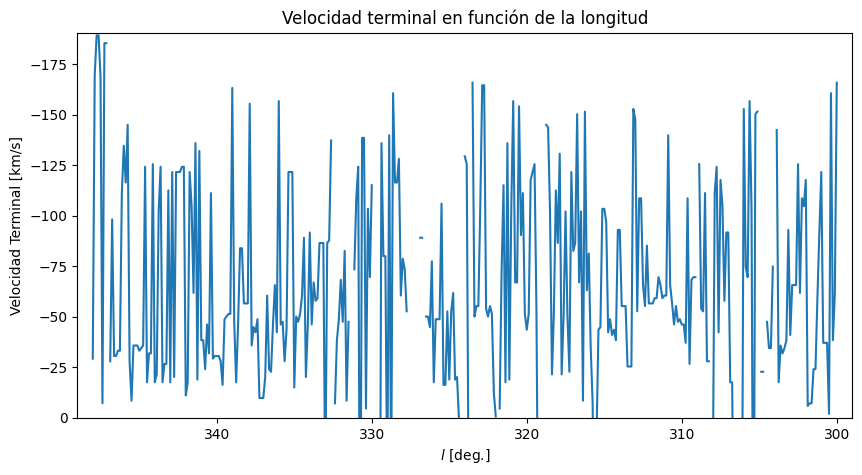

In [95]:
# Prueba para visualizar que se consigue en el DataFrame 
# Como se puede ver, aún falta procesar los datos, 
# pero se puede ver algunos casos en que se registran NaN!

l_1 = [table['longitude l'][i] for i in range(385)]
v_1 = [table['v_tan'][i] for i in range(385)]

plt.figure(figsize = (10, 5))
plt.plot(l_1, v_1)
plt.xlim(349, 299.)
plt.ylim(0, np.min(vt_lon))
plt.xlabel(r'$l$ [deg.]')
plt.ylabel(r'Velocidad Terminal [km/s]')
plt.title('Velocidad terminal en función de la longitud')
plt.show()

In [96]:
# Falta escoger el mínimo para cada latitud 
# (conseguir solo un valor por latitud, 
# un proceso similar al anterior pero menos complejo) 

min_per_lat = np.zeros((len(lat), 2))
for i, b in enumerate(lat):
    table_b = table.loc[table['latitude b'] == b]
    min_vel = table_b['v_tan'].min()
    min_per_lat[i] = [b, min_vel]

# Ahora lo mismo pero con los mínimos por longitud

min_per_lon = np.zeros((len(lon), 2))
for i, l in enumerate(lat):
    table_b = table.loc[table['longitude l'] == l]
    min_vel = table_b['v_tan'].min()
    min_per_lat[i] = [l, min_vel]

## Implementación

### Constantes a usar en los cálculos de la curva de rotación

* $R_{0} = 8.5 [kpc]$
* $V(R_{0}) \sim 220 [\frac{km}{s}]$
* $\omega_{0} = \frac{V(R_{0})}{R_{0}} \sim 25.882 [\frac{km}{s\cdot kpc}]$

### Objetivo: 
 
Calcular la velocidad rotacional dada por 

\begin{align}
V(R = R_0 \sin(l)) = \omega(R = R_0 \sin(l)) \cdot R_0 \cdot |\sin(l)|
\end{align}

In [97]:
# Constantes mencionadas anteriormente

R0 = 8.5   # kpc
vsun = 220 # km/s
w0 = vsun/R0

# En la siguiente función se resume todo lo visto antes, pero en la definición esta es general
# para cualquier largo de datos que se tenga (se podría utilizar con otros archivos FITS)

def fmin(l, latitude, velocity, vs):
    #   Iteramos sobre la latitud 
        for b in range(len(latitude)):
    #       Vemos las velocidades de un (b, l) 
            T1 = data[b][l][:] 
            rms = np.sqrt(np.mean(T1**2))   # Calculo de RMS de ese array de vel
    #       Iteraciones sobre la velocidad
            for v in range(len(velocity)):
                if data[b][l][v] >= 5 * rms:  # Condicional para filtrar ruido
                    vs[b] = velocity[v]    # Se guarda la primera velocidad que no sea ruido
                    break

In [100]:
# Cómo buscamos el maximorum sobre la longitud, debemos crear otra función que toma la longitud y entregue 
# los arrays de velocidades minimas y de sus correpondientes latitudes, además del array de R

def maximorums(longitude, latitude, velocity):
    n_b = len(longitude)
    n_l = len(latitude)
    vmin = np.zeros(n_b)
    bvmin = np.zeros(n_b)
    R = np.zeros(n_b)
    for i in range(n_b):
        vs = np.zeros(n_l)
        fmin(i, latitude, velocity, vs)
        v1 = vs[0]
        b1 = latitude[0]
        for j in range(n_l - 1):
            if vs[j + 1] < v1:
                v1 = vs[j + 1]
                b1 = latitude[j + 1]
        vmin[i] = v1
        bvmin[i] = b1
        R[i] = np.abs(R0 * np.sin(np.radians(longitude[i])))

    return vmin, bvmin, R

# Ahora creamos una última función que devuelva el V(R) final que 
# buscamos para graficar la curvatura de la galaxia

def vr(longitude, vmin):
    n_b = len(longitude)
    b_rad = np.radians(longitude)
    vR = np.zeros(n_b)
    for b in range(n_b):
        vR[b] = vmin[b] * (np.abs(np.sin(b_rad[b]))) / np.sin(b_rad[b]) + np.abs(vsun * np.sin(b_rad[b]))

    return vR


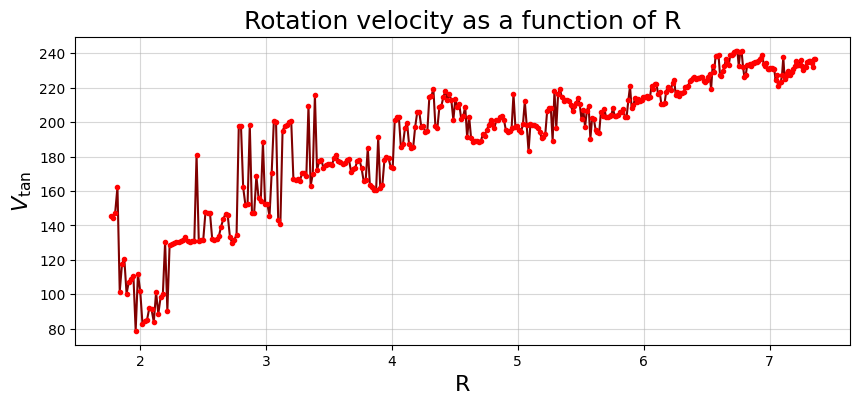

In [101]:
# Aplicando las funciones a nuestros datos podremos graficar la curva de rotación  
# como V_rot vs R, inicialmente

vmin, bvmin, R = maximorums(lon, lat, vel)

vR = vr(lon, vmin)

plt.figure(figsize=(10, 4))
plt.plot(R,vR, 'maroon')
plt.plot(R,vR, 'r.')
plt.grid
plt.title("Rotation velocity as a function of R", fontsize=18)
plt.xlabel("R", fontsize=16)
plt.ylabel(r"$V_{\mathrm{tan}}$", fontsize=16)
plt.grid(alpha=0.5)